In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
data_dir = '../kaggle_data/'

In [3]:
kaggle_train = data_dir+'train.csv'
kaggle_test  = data_dir+'test.csv'

In [4]:
df_orig = pd.read_csv(kaggle_train)
df_extrap = pd.read_csv(kaggle_test)
import copy
df = copy.copy(df_orig)
#df_train,df_cv = train_test_split(pd.read_csv(kaggle_train))

In [5]:
N = len(df[df['target']==0])
N = 5000

In [6]:
#df_train.sortlevel()

# df['null_count'] = df.isnull().sum(axis=1)
# df = df[df['null_count']<10]
# df.drop('null_count',axis=1,inplace=True)

In [7]:
# BALANCE THE CLASSES

mask1 = df['target']==1
mask0 = df['target']==0
#N = 5000
df = pd.concat([df[mask1].sample(N), df[mask0].sample(N)])

In [8]:
# df = df.sample(frac=0.1)
# len(df.index)

In [9]:
person_id = df['ID']
y_df = df['target']
y_df_orig = df_orig['target']
y_df.index = df['ID']
y_df_orig.index = df_orig['ID']
category_features = ['v24','v30','v31','v47','v52','v56','v66',\
                     'v74','v75','v79','v91','v107','v110','v112','v113','v125']
complicated_category_features = ['v3','v22','v52','v71']
integer_features = ['v38','v62','v72','v129']

non_numeric = ['ID','target']+category_features+complicated_category_features
numeric_features = []
for c in df.columns:
    if c not in non_numeric:
        numeric_features.append(c)


In [10]:
# df[integer_features]

In [11]:
df_cat = df[category_features]
df_cat_orig = df_orig[category_features]
df_cat_extrap = df_extrap[category_features]
df_cat.index = df['ID']
df_cat_orig.index = df_orig['ID']
df_cat_extrap.index = df_extrap['ID']

In [12]:
# # OPTIONAL: FILL NANS WITH MODE OF GROUP
# for c in df_cat.columns.values:
#     df_cat[c] = df_cat[c].fillna(df_cat[c].mode())
df_cat = pd.get_dummies(df_cat,dummy_na=True)
df_cat_orig = pd.get_dummies(df_cat_orig,dummy_na=True)
df_cat_extrap = pd.get_dummies(df_cat_extrap,dummy_na=True)

In [13]:
# for c in df_cat.columns.values:
#     print(c)
#     print(df_cat[c].value_counts())

In [14]:
df_num = df[numeric_features]
df_num_orig = df_orig[numeric_features]
df_num_extrap = df_extrap[numeric_features]


In [15]:
for c in df_num.columns.values:
    df_num[c] = df_num[c].fillna(df_num[c].mean())
    df_num_orig[c] = df_num_orig[c].fillna(df_num_orig[c].mean())
    df_num_extrap[c] = df_num_extrap[c].fillna(df_num_extrap[c].mean())
df_num.index = df['ID']
df_num_orig.index = df_orig['ID']
df_num_extrap.index = df_extrap['ID']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [16]:
X_df = df_num.merge(df_cat,how='inner',left_index=True,right_index=True)
X_df_orig = df_num_orig.merge(df_cat_orig,how='inner',left_index=True,right_index=True)

X_df_extrap = df_num_extrap.merge(df_cat_extrap,how='inner',left_index=True,right_index=True)


In [17]:
X_df['Target'] = y_df.values
X_df_orig['Target'] = y_df_orig.values
#X_df_extrap['Target'] = y_df_extrap.values

In [18]:
df_train,df_test = train_test_split(X_df)

In [19]:
y_df_train = df_train['Target']
X_df_train = df_train.drop(['Target'],axis=1)
y_df_test = df_test['Target']
X_df_test = df_test.drop(['Target'],axis=1)
X_df_orig = X_df_orig.drop(['Target'],axis=1)

In [20]:
X_train = X_df_train.values
y_train = y_df_train.values
X_test = X_df_test.values
y_test = y_df_test.values
X_orig = X_df_orig.values
y_orig = y_df_orig.values

X_extrap = X_df_extrap.values

# X_train = X_df_train[imp_features].values
# y_train = y_df_train.values
# X_test = X_df_test[imp_features].values
# y_test = y_df_test.values

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC

In [22]:
#clf = LogisticRegression(C=0.01)
#clf = RandomForestClassifier(max_depth=13)
clf = XGBC(learning_rate=0.02,n_estimators=300,max_depth=7)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

TRAINING SET:


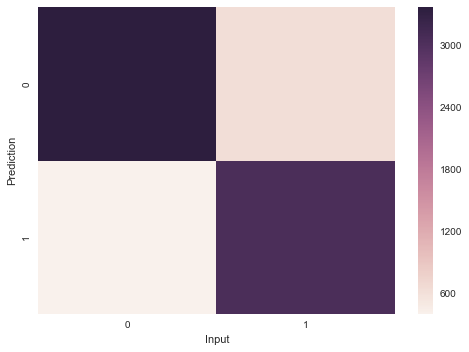

TEST SET:


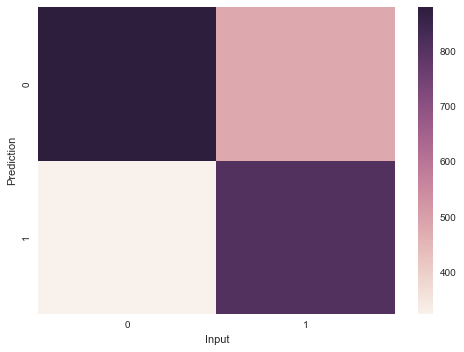

UNBALANCED SET:


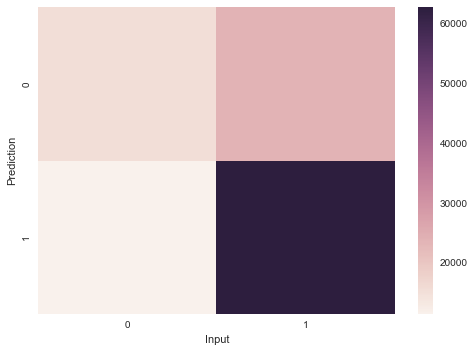

In [23]:
# Predictions on training
print("TRAINING SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(clf.predict(X_train),y_train))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

# Predictions on test
print("TEST SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(clf.predict(X_test),y_test))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

# Predictions on unbalanced set
print("UNBALANCED SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(clf.predict(X_orig),y_orig))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

In [24]:
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
print(clf.score(X_orig,y_orig))

0.8616
0.676
0.687161588859


In [25]:
# perc_balance = 1.0*len(df_orig[df_orig['target']==1].index) / (len(df_orig[df_orig['target']==0].index)+\
#                                                     len(df_orig[df_orig['target']==1].index))

In [26]:
chance_0 = clf.predict_proba(X_orig)[:,1]


# zeros = np.where(chance_0>np.percentile(chance_0,perc_balance*100))
# ones  = np.where(chance_0<=np.percentile(chance_0,perc_balance*100))

# # unbalanced_set = np.ones(len(X_test))
# # unbalanced_set[zeros]=0

# chance_0 = chance_0**2

# zeros = np.where(chance_0>np.percentile(chance_0,50))
# ones  = np.where(chance_0<=np.percentile(chance_0,50))

# unbalanced_set = np.ones(len(X_test))
# unbalanced_set[zeros]=0

In [27]:
chance_0

array([ 0.59141701,  0.55533445,  0.61863852, ...,  0.8915838 ,
        0.55967075,  0.57215351], dtype=float32)

(array([   698.,   2627.,   6602.,  11818.,  19907.,  23846.,  18099.,
         12516.,  10727.,   7481.]),
 array([ 0.03206874,  0.12711042,  0.2221521 ,  0.31719378,  0.41223546,
         0.50727713,  0.60231881,  0.69736049,  0.79240217,  0.88744385,
         0.98248553]),
 <a list of 10 Patch objects>)

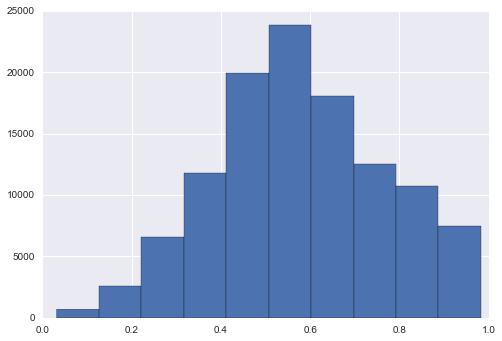

In [28]:
plt.hist(chance_0)

In [29]:
chance_1_out =  clf.predict_proba(X_extrap)[:,1]

In [30]:


# # Predictions on test
# print("TEST SET:")
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# ax = sns.heatmap(confusion_matrix(unbalanced_set,y_test))
# ax.set_xlabel('Input')
# ax.set_ylabel('Prediction')
# plt.show()

# print(confusion_matrix(unbalanced_set,y_test))

In [31]:
# 1.0*np.sum(unbalanced_set==y_test) / np.size(y_test)

In [32]:
# importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]
# cols = X_df_train.columns.values
# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")

# lim = -1
# plt.bar(range(X_train.shape[1])[:lim], importances[indices][:lim],
#        color="r", yerr=std[indices][:lim], align="center")
# plt.xticks(range(X_train.shape[1])[:lim], np.array(cols)[indices[:lim]])
# plt.xlim([-1, max(np.arange(X_train.shape[1])[:lim])])
# plt.show()

In [33]:
# imp_features = cols[importances>0.002]

In [34]:
out_df = pd.DataFrame({'ID':df_extrap['ID'],'PredictedProb':chance_1_out})

In [35]:
out_df.to_csv('dmw_attempt_1.csv',index=False)